# Eval


In [2]:
import sys
import os
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc

current_dir = Path.cwd()
if str(current_dir.parent) not in sys.path:
    sys.path.append(str(current_dir.parent))

# Import your modules
try:
    from ttv.models import SiameseFusion
    from ttv.config import CFG
    from ttv.data import SixStreamGaitDataset
except ImportError:
    # Fallback if running from root
    from models import SiameseFusion
    from config import CFG
    from data import SixStreamGaitDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


### CONFIGURATION

In [3]:
# --- 1. SETUP PATHS WITH PATHLIB ---
# Get current directory (where notebook is)
CURRENT_DIR = Path.cwd()

# Assuming structure: verf/ttv/ttv.ipynb
# We want to add 'verf' (parent) to path to import modules

PARENT_DIR = CURRENT_DIR.parent 
if str(PARENT_DIR) not in sys.path:
    sys.path.append(str(PARENT_DIR))

In [4]:
# PASTE YOUR RUN TIMESTAMP HERE (from the start of training logs)
TIMESTAMP = "251214_2041" 

In [5]:

# Define Directories using Path
DATA_DIR = PARENT_DIR / "processed_tensors"

# Looks for: verf/test_subjects-251214_1450.txt
test_subjs_file = CURRENT_DIR / f"test_subjects-{TIMESTAMP}.txt"

In [6]:
# 1. Locate Test Subjects File
if not test_subjs_file.exists():
    print(f"⚠️ WARNING: Test split file not found: {test_subjs_file}")
    print("Using ALL data (High risk of data leakage!)")
    test_subjs = []
else:
    print(f"✅ Found Test Split: {test_subjs_file.name}")
    with open(test_subjs_file, 'r') as f:
        test_subjs = [line.strip() for line in f.readlines()]

# 2. Locate Model Checkpoint
# Default: verf/ttv/best_gait_model.pth
# Logic: Checks if you have a timestamped model, otherwise falls back to standard
model_candidates = [
    CURRENT_DIR / f"best_gait_model-{TIMESTAMP}.pth"#, # Explicit timestamp
    # CURRENT_DIR / "best_gait_model.pth",              # Standard (Latest)
    # PARENT_DIR / "best_gait_model.pth"                # Fallback location
]

✅ Found Test Split: test_subjects-251214_2041.txt


In [7]:

model_path = None
for candidate in model_candidates:
    if candidate.exists():
        model_path = candidate
        break

if not model_path:
    raise FileNotFoundError(f"❌ No model checkpoint found for timestamp {TIMESTAMP} or standard name.")

print(f"✅ Using Model: {model_path.name}")
print(f"Loaded {len(test_subjs)} test subjects.")

✅ Using Model: best_gait_model-251214_2041.pth
Loaded 14 test subjects.


###  MODEL & DATA

In [8]:
# Initialize Model Architecture
model = SiameseFusion(cfg=CFG).to(device)

print(f"Loading weights from {model_path.name}...")
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load Data Files
# Using Path.glob() instead of glob.glob
print("Scanning for data files...")
all_files = list(DATA_DIR.glob("*.pt"))

if not all_files:
    raise FileNotFoundError(f"No .pt files found in {DATA_DIR}")

test_data = {}
print("Loading Test Data...")
for f in tqdm(all_files):
    sid = f.stem # 'S001' from '.../S001.pt'
    
    # Only load if it's in our test list (or if list is empty)
    if not test_subjs or sid in test_subjs:
        test_data[sid] = torch.load(f)

print(f"Loaded {len(test_data)} test subjects.")

Loading weights from best_gait_model-251214_2041.pth...
Scanning for data files...
Loading Test Data...


  0%|          | 0/84 [00:00<?, ?it/s]

Loaded 14 test subjects.


### Feature Extraction

In [9]:
# Create Dataset using your new Class
# We override stride to 200 for evaluation (no overlap needed)
ds = SixStreamGaitDataset(test_data, cfg=CFG, mode='test', override_stride=200)
loader = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=False)

embeddings = []
labels = []

print("Extracting Features...")
with torch.no_grad():
    for batch, pids in tqdm(loader):
        # Move inputs to GPU
        for k in batch.keys():
            batch[k] = batch[k].to(device)
            
        # Forward pass (Get Anchor embedding)
        # The model returns (emb, emb, emb) for triplet, we just need one
        emb, _, _ = model(batch, batch, batch) 
        
        embeddings.append(emb.cpu().numpy())
        labels.extend(pids)

embeddings = np.concatenate(embeddings)
labels = np.array(labels)
print(f"Extraction Complete. Shape: {embeddings.shape}")

Extracting Features...


  0%|          | 0/938 [00:00<?, ?it/s]

Extraction Complete. Shape: (60000, 64)


### Nomralisation

In [10]:
# --- CRITICAL STEP ---
# Normalize to enforce Cosine Similarity on the Unit Hypersphere
print("Normalizing embeddings (L2)...")
embeddings = normalize(embeddings, norm='l2')

Normalizing embeddings (L2)...


### Visuals

In [11]:
def compute_metrics_histogram(embeddings, labels, block_size=1000, n_bins=20000):
    # Setup
    le = LabelEncoder()
    labels_int = le.fit_transform(labels)
    emb_tensor = torch.tensor(embeddings, dtype=torch.float32, device=device)
    lbl_tensor = torch.tensor(labels_int, device=device)
    
    # Bins for Euclidean Dist (0.0 to 2.0)
    bins = np.linspace(0.0, 2.0, n_bins + 1)
    gen_hist = np.zeros(n_bins, dtype=np.int64)
    imp_hist = np.zeros(n_bins, dtype=np.int64)
    
    n_samples = len(emb_tensor)
    
    with torch.no_grad():
        for i in tqdm(range(0, n_samples, block_size), desc="Computing Histograms"):
            end_i = min(i + block_size, n_samples)
            query_emb = emb_tensor[i:end_i]
            query_lbl = lbl_tensor[i:end_i]
            
            # Distances
            dists = torch.cdist(query_emb, emb_tensor, p=2)
            mask = query_lbl.unsqueeze(1) == lbl_tensor.unsqueeze(0)
            
            # Genuine
            g_dists = dists[mask]
            g_dists = g_dists[g_dists > 1e-5].cpu().numpy() # Remove self-loops
            gh, _ = np.histogram(g_dists, bins=bins)
            gen_hist += gh
            
            # Imposter
            i_dists = dists[~mask].cpu().numpy()
            ih, _ = np.histogram(i_dists, bins=bins)
            imp_hist += ih
            
            del dists, mask, g_dists, i_dists
            
    return gen_hist, imp_hist, bins

In [12]:

# Run it
gen_hist, imp_hist, bins = compute_metrics_histogram(embeddings, labels)

Computing Histograms:   0%|          | 0/60 [00:00<?, ?it/s]

### Calculate EER & ROC

FINAL EER: 33.20%
Threshold: 0.1689
TPR: [0. 0. 0. ... 1. 1. 1.] | FPR :[0. 0. 0. ... 1. 1. 1.] | FNR:[1. 1. 1. ... 0. 0. 0.]


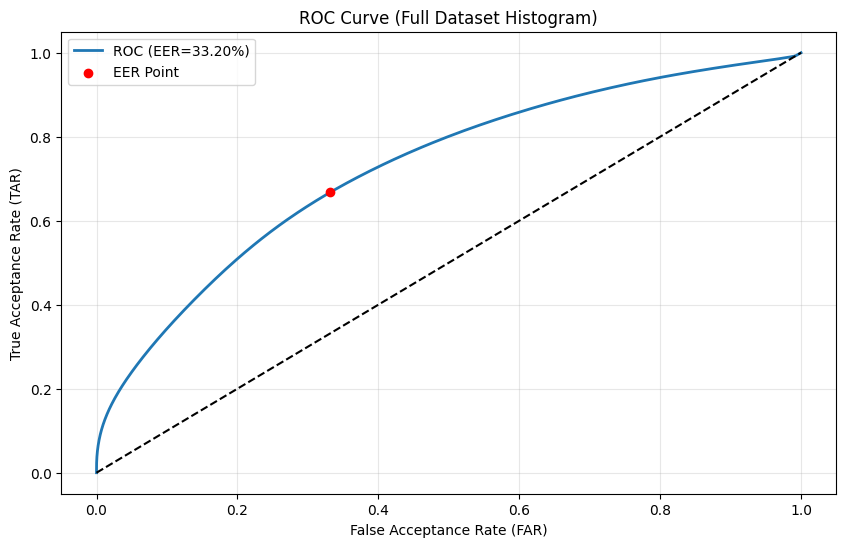

In [13]:
# Calculate CDFs
gen_cdf = np.cumsum(gen_hist) / np.sum(gen_hist)
imp_cdf = np.cumsum(imp_hist) / np.sum(imp_hist)

# TPR (True Accept Rate) = gen_cdf
# FPR (False Accept Rate) = imp_cdf
tpr = gen_cdf
fpr = imp_cdf
fnr = 1 - tpr

# Find EER
diffs = np.abs(fpr - fnr)
min_idx = np.argmin(diffs)
eer = fpr[min_idx]
thresh = bins[min_idx]

print(f"===================================")
print(f"FINAL EER: {eer*100:.2f}%")
print(f"Threshold: {thresh:.4f}")
print(f"TPR: {tpr} | FPR :{fpr} | FNR:{fnr}")
print(f"===================================")

# Plot ROC
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label=f"ROC (EER={eer:.2%})", linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.scatter(fpr[min_idx], tpr[min_idx], color='red', zorder=5, label='EER Point')
plt.xlabel("False Acceptance Rate (FAR)")
plt.ylabel("True Acceptance Rate (TAR)")
plt.title("ROC Curve (Full Dataset Histogram)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Confusion Matrix

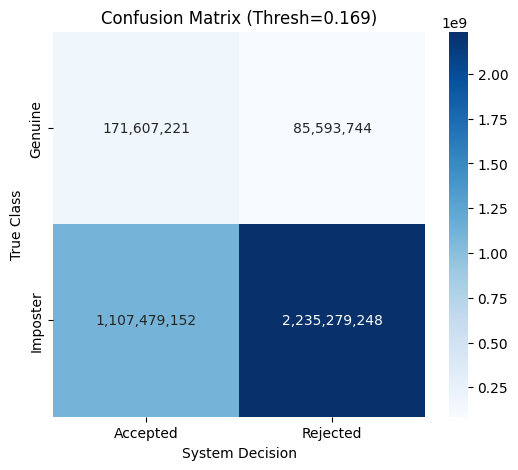

In [14]:
# Estimate counts based on histogram at threshold
# Genuine
tp_count = np.sum(gen_hist[:min_idx])
fn_count = np.sum(gen_hist[min_idx:])
# Imposter
fp_count = np.sum(imp_hist[:min_idx])
tn_count = np.sum(imp_hist[min_idx:])

matrix = np.array([[tp_count, fn_count], [fp_count, tn_count]])

plt.figure(figsize=(6,5))
sns.heatmap(matrix, annot=True, fmt=",d", cmap="Blues",
            xticklabels=["Accepted", "Rejected"],
            yticklabels=["Genuine", "Imposter"])
plt.title(f"Confusion Matrix (Thresh={thresh:.3f})")
plt.ylabel("True Class")
plt.xlabel("System Decision")
plt.show()

# end

: 

: 

: 

#### Old test file

In [ ]:
# Cell 1
import sys
import os
from pathlib import Path

# ... other imports ...

# ADD PARENT DIR
current_dir = Path.cwd()
if str(current_dir.parent) not in sys.path:
    sys.path.append(str(current_dir.parent))

# IMPORT FROM NEW MODULES
try:
    # Try importing as a package first (verf.ttv.models)
    from ttv.models import SiameseFusion
    from ttv.config import CFG
    from ttv.data import SixStreamGaitDataset
except ImportError:
    # Fallback: Import directly if files are in the same folder
    from models import SiameseFusion
    from config import CFG
    from data import SixStreamGaitDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


: 

: 

: 